# Global imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils_data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Thu Feb 11 19:37:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pix2pix architecture

In [5]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=2, norm=True, dropout=False, network='encoder'):
        super(ConvBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(4, 4), stride=stride, padding=1) if network == 'encoder' else\
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(4, 4), stride=stride, padding=1),
            nn.BatchNorm2d(out_channels) if norm else nn.Identity(),
            nn.Dropout2d(0.5) if dropout else nn.Identity(),
            nn.LeakyReLU(0.2) if network == 'encoder' else nn.ReLU()
        )
    
    def forward(self, x):
        return self.conv_block(x)

In [6]:
class UNetGenerator(nn.Module):

    def __init__(self, in_channels=3, out_channels=3, ihs=64):
        """
        Parameters:
            in_channels (int) - number of input channels,
            ihs (int) - initial hidden size for conv blocks
        """
        super(UNetGenerator, self).__init__()

        self.encoder_layers = nn.ModuleList(
            [ ConvBlock(in_channels, ihs, norm=False) ] + [ ConvBlock(int(ihs * 2**i), int(ihs * 2**(i+1))) for i in range(3) ] +\
            [ ConvBlock(ihs * 8, ihs * 8) for i in range(3) ]
        )

        self.bottleneck_layer = nn.Sequential(
            ConvBlock(ihs * 8, ihs * 8, norm=False),
            ConvBlock(ihs * 8, ihs * 8, dropout=True, network='decoder')
        )

        self.decoder_layers = nn.ModuleList(
            [ ConvBlock(ihs * 8 * 2, ihs * 8, dropout=(True if i < 2 else False), network='decoder') for i in range(3) ] +\
            [ ConvBlock(int(ihs * 2**i) * 2, int(ihs * 2**(i-1)), network='decoder') for i in range(3, 0, -1) ]
        )

        self.output_layer = nn.Sequential(
            nn.ConvTranspose2d(ihs * 2, out_channels, kernel_size=(4, 4), stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        enc_outs = []
        for i, layer in enumerate(self.encoder_layers):
            enc_in = x if i == 0 else enc_outs[-1]
            enc_outs.append( layer(enc_in) )

        b = self.bottleneck_layer(enc_outs[-1])

        dec_outs = []
        for i, layer in enumerate(self.decoder_layers):
            dec_in = b if i == 0 else dec_outs[-1]
            dec_outs.append( layer( torch.cat((dec_in, enc_outs[-i-1]), dim=1) ) )
        
        out = self.output_layer( torch.cat((dec_outs[-1], enc_outs[0]), dim=1) )
        
        return out

In [7]:
class PatchGAN(nn.Module):
    """
    70x70 PatchGAN discriminator from paper.
    """

    def __init__(self, in_channels=3, ihs=64):
        super(PatchGAN, self).__init__()

        self.discriminator_layers = nn.Sequential(
            ConvBlock(in_channels * 2, ihs, norm=False),
            ConvBlock(ihs, ihs * 2),
            ConvBlock(ihs * 2, ihs * 4),
            ConvBlock(ihs * 4, ihs * 8, stride=1)
        )

        self.output_layer = nn.Conv2d(ihs * 8, 1, kernel_size=(4, 4), padding=1)
    
    def forward(self, input, ground_truth):
        x = torch.cat((input, ground_truth), dim=1)
        x = self.discriminator_layers(x)
        x = self.output_layer(x)

        return x

# Loss functions

In [8]:
class DiscriminatorLoss(nn.Module):
    
    def __init__(self):
        super(DiscriminatorLoss, self).__init__()
        self.log_sigmoid = nn.LogSigmoid()

    def forward(self, d_real, d_gen):
        return -0.5 * (self.log_sigmoid(d_real) + self.log_sigmoid(1.0 - d_gen)).mean()

class GeneratorLoss(nn.Module):

    def __init__(self, lam=100):
        super(GeneratorLoss, self).__init__()
        self.lam = lam
        self.log_sigmoid = nn.LogSigmoid()
        self.l1_loss = nn.L1Loss()
    
    def forward(self, y_gen, y, d_gen):
        return -self.log_sigmoid(d_gen).mean() + self.lam * self.l1_loss(y_gen, y)

# Utility functions and training

In [9]:
import itertools

# from pytorch-pix2pix
def show_images(G, X_test, y_test, num_epoch, figsize=(10, 10)):
    G.eval()
    test_images = G(X_test.to(device))

    size_figure_grid = 3
    fig, ax = plt.subplots(X_test.size()[0], size_figure_grid, figsize=figsize)
    for i, j in itertools.product(range(X_test.size()[0]), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for i in range(X_test.size()[0]):
        ax[i, 0].cla()
        ax[i, 0].imshow((X_test[i].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)
        ax[i, 1].cla()
        ax[i, 1].imshow((test_images[i].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)
        ax[i, 2].cla()
        ax[i, 2].imshow((y_test[i].numpy().transpose(1, 2, 0) + 1) / 2)

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.show()

In [10]:
from IPython import display
from time import time
from tqdm.autonotebook import tqdm

def train(n_epochs, G, D, opt_G, opt_D, criterion_G, criterion_D, train_loader, val_batch, verbose=True, freq=None):
    if verbose and freq is None:
        freq = max(1, n_epochs // 10)
    
    loss_history_D, loss_history_G = [], []

    D.train()

    time_start = time()
    for epoch in range(1, n_epochs + 1):
        
        G.train()
        loss_D, loss_G = 0., 0.
        for X, y in tqdm(train_loader):
            X = X.to(device)
            y = y.to(device)

            # train discriminator

            y_gen  = G(X)
            d_real = D(X, y).squeeze()
            d_fake = D(X, y_gen).squeeze()

            d_loss = criterion_D(d_real, d_fake)

            # backpropagation
            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()

            loss_D += d_loss.item()

            # train generator

            y_gen  = G(X)
            d_fake = D(X, y_gen).squeeze()

            g_loss = criterion_G(y_gen, y, d_fake)

            # backpropagation
            opt_G.zero_grad()
            g_loss.backward()
            opt_G.step()

            loss_G += g_loss.item()
        loss_D /= len(train_loader)
        loss_G /= len(train_loader)

        loss_history_D.append( loss_D )
        loss_history_G.append( loss_G )

        if verbose and epoch % freq == 0:
            display.clear_output(wait=True)

            plt.figure(figsize=(15, 5))

            plt.subplot(1, 2, 1)
            plt.plot(loss_history_G)
            plt.title("Generator loss")
            plt.xlabel("Epoch")
            plt.ylabel("G-Loss")
            
            plt.subplot(1, 2, 2)
            plt.plot(loss_history_D)
            plt.title("Discriminator loss")
            plt.xlabel("Epoch")
            plt.ylabel("D-Loss")

            plt.show()
            
            show_images(G, val_batch[0], val_batch[1], epoch)

            print("[  Epoch {}  ]".format(epoch))
            print("Generator loss: {} | Discriminator loss: {}".format(loss_G, loss_D))
            print("Elapsed time: {} s".format(time() - time_start))
    
    return loss_history_G, loss_history_D

In [11]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.InstanceNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.zero_()

In [12]:
def GAN_inference(G, image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    tensor_image = transform(image).unsqueeze(0)
    generated_image = G(tensor_image.to(device)).squeeze(0)

    plt.imshow((generated_image.cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)
    plt.axis('off')
    plt.show()
    
    return generated_image.cpu()

In [13]:
import os
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as tf

class Pix2PixDataset(utils_data.Dataset):

    def __init__(self, path, img_size=256, base_transform=None, train_transforms=True, inverse=True):
        super(Pix2PixDataset, self).__init__()

        self.base_transform = base_transform
        self.train_transforms = train_transforms
        self.inverse = inverse

        self.img_size = img_size
        self.img_paths = [ path + img_path for img_path in os.listdir(path) ]

    def __len__(self):
        return len(self.img_paths)
    
    def sample_loader(self, img_path):
        img = Image.open(img_path)
        return img.convert("RGB")

    def jitter(self, mask, image):
        # Resize
        resize = transforms.Resize(size=(286, 286))
        image = resize(image)
        mask = resize(mask)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            image, output_size=(256, 256))
        image = tf.crop(image, i, j, h, w)
        mask = tf.crop(mask, i, j, h, w)

        return mask, image

    def transform(self, mask, image):
        mask, image = self.jitter(mask, image)

        p = np.random.random()
        if p > 0.5:
            mask, image = tf.hflip(mask), tf.hflip(image)
        
        return mask, image
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img = self.sample_loader(self.img_paths[idx])
        if self.base_transform:
            img = self.base_transform(img)
        
        if self.inverse:
            X = img[:, :, self.img_size:]
            y = img[:, :, :self.img_size]
        else:
            X = img[:, :, :self.img_size]
            y = img[:, :, self.img_size:]
        
        if self.train_transforms:
            X, y = self.transform(X, y)

        return X, y

# Задача 1: решенная задача из оригинальной статьи - рисование фасадов зданий из наброска

## Training on facades dataset

dataset link: https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz

In [24]:
print (os.listdir('/content/drive/MyDrive/DLS'))

['facades.tar.gz']


In [28]:
!tar xzvf /content/drive/MyDrive/DLS/facades.zip#tar.gz

tar (child): /content/drive/MyDrive/DLS/facades.zip#tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [32]:
#DATA_DIR = '/content/facades'
DATA_DIR = '/content/drive/MyDrive/facades'
base_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dataset = Pix2PixDataset(DATA_DIR + "/train/", base_transform=base_transform)
val_dataset  = Pix2PixDataset(DATA_DIR + "/test/", base_transform=base_transform, train_transforms=False)

train_loader = utils_data.DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader  = utils_data.DataLoader(val_dataset, batch_size=5, shuffle=True)
val_batch = val_loader.__iter__().__next__()

IsADirectoryError: ignored

In [ ]:
generator = UNetGenerator().to(device)
discriminator = PatchGAN().to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

opt_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

criterion_G = GeneratorLoss()
criterion_D = DiscriminatorLoss()

In [ ]:
loss_history_G, loss_history_D = train(200, generator, discriminator, opt_G, opt_D, criterion_G, criterion_D, train_loader, val_batch, verbose=True, freq=1)

In [ ]:
torch.save(generator.state_dict(), "g_facade.pth")
torch.save(discriminator.state_dict(), "d_facade.pth")

## Inference on facades dataset

In [ ]:
G = UNetGenerator()
G.load_state_dict(torch.load("/content/g_facade.pth"))
G.to(device)

In [ ]:
test_dataset = Pix2PixDataset(DATA_DIR + "/test/", base_transform=base_transform, train_transforms=False)
test_loader  = utils_data.DataLoader(test_dataset, batch_size=5, shuffle=True)

In [ ]:
test_batch = test_loader.__iter__().__next__()
show_images(G, test_batch[0], test_batch[1], 200, figsize=(15, 15))

In [ ]:
test_batch = test_loader.__iter__().__next__()
show_images(G, test_batch[0], test_batch[1], 200, figsize=(15, 15))

In [ ]:
img = Image.open("/content/facades/test/10.jpg").crop((256, 0, 512, 256))
gen_img = GAN_inference(G, img)

In [ ]:
img = Image.open("/content/facades/test/8.jpg").crop((256, 0, 512, 256))
gen_img = GAN_inference(G, img)

In [ ]:
img = Image.open("/content/facades/test/22.jpg").crop((256, 0, 512, 256))
gen_img = GAN_inference(G, img)

# Задача 2: собственная задача - рисование картин на основе набросков (датасет из пар набросок - картина на основе работ Айвазовского)

## Training on paintings dataset

dataset link: https://www.kaggle.com/grafstor/aivazovsky-pix2pix-dataset

In [29]:
!unzip -q /content/drive/MyDrive/DLS/paintings.zip -d paintings

unzip:  cannot find or open /content/drive/MyDrive/DLS/paintings.zip, /content/drive/MyDrive/DLS/paintings.zip.zip or /content/drive/MyDrive/DLS/paintings.zip.ZIP.


In [30]:
#!rm -rf '/content/paintings'

In [31]:
# preparation
DATA_DIR ='/content/drive/MyDrive/pix2pix'# '/content/paintings/pix2pix'

img_list = os.listdir(DATA_DIR)

n_imgs = len(img_list)
train_size = int(n_imgs * 0.8)

rng = np.random.default_rng()
train_idxs = rng.choice(n_imgs, size=train_size, replace=False)

for idx in train_idxs:
    os.rename(DATA_DIR + "/{}".format(img_list[idx]), "/content/paintings/train/{}".format(img_list[idx]))

FileNotFoundError: ignored

In [34]:
TRAIN_DIR = '/content/drive/MyDrive/pix2pix/pix2pixtrain/'
TEST_DIR  = '/content/drive/MyDrive/pix2pix/pix2pixtest/'

base_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dataset = Pix2PixDataset(TRAIN_DIR, base_transform=base_transform, inverse=False)
test_dataset  = Pix2PixDataset(TEST_DIR, base_transform=base_transform, train_transforms=False, inverse=False)

train_loader = utils_data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = utils_data.DataLoader(test_dataset, batch_size=5, shuffle=True)
test_batch = test_loader.__iter__().__next__()

In [35]:
generator = UNetGenerator().to(device)
discriminator = PatchGAN().to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

opt_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

criterion_G = GeneratorLoss()
criterion_D = DiscriminatorLoss()

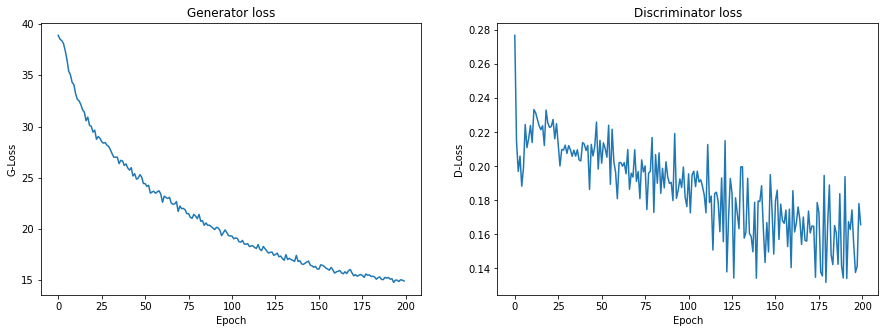

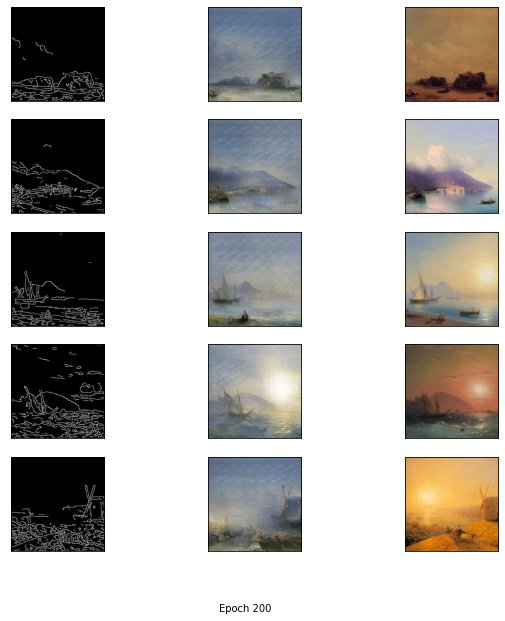

[  Epoch 200  ]
Generator loss: 14.920577057291952 | Discriminator loss: 0.16574971692170948
Elapsed time: 8324.314851522446 s


In [36]:
loss_history_G, loss_history_D = train(200, generator, discriminator, opt_G, opt_D, criterion_G, criterion_D, train_loader, test_batch, verbose=True, freq=1)

In [37]:
torch.save(generator.state_dict(), "g_paintings.pth")
torch.save(discriminator.state_dict(), "d_paintings.pth")

## Inference on paintings dataset

In [ ]:
G = UNetGenerator()
G.load_state_dict(torch.load("/content/g_paintings.pth"))
G.to(device)

In [ ]:
test_dataset = Pix2PixDataset(TEST_DIR, base_transform=base_transform, train_transforms=False, inverse=False)
test_loader  = utils_data.DataLoader(test_dataset, batch_size=5, shuffle=True)

In [ ]:
test_batch = test_loader.__iter__().__next__()
show_images(G, test_batch[0], test_batch[1], 200, figsize=(15, 15))

In [ ]:
test_batch = test_loader.__iter__().__next__()
show_images(G, test_batch[0], test_batch[1], 200, figsize=(15, 15))

In [ ]:
img = Image.open("/content/paintings/test/108.jpg").crop((0, 0, 256, 256))
gen_img = GAN_inference(G, img)

In [ ]:
img = Image.open("/content/paintings/test/18.jpg").crop((0, 0, 256, 256))
gen_img = GAN_inference(G, img)

In [ ]:
img = Image.open("/content/paintings/test/291.jpg").crop((0, 0, 256, 256))
gen_img = GAN_inference(G, img)